In [1]:
tier_list = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'EMERALD', 'PLATINUM', 'DIAMOND', 'MASTER', 'GRANDMASTER', 'CHALLENGER']
division_list = ['I', 'II', 'III', 'IV'][::-1]
new_tier_list = []

for tier in tier_list:

    if tier not in ['MASTER', 'GRANDMASTER', 'CHALLENGER']:

        for division in division_list:

            new_tier_list.append(f'{tier}_{division}')

tier_list = new_tier_list + ['MASTER', 'GRANDMASTER', 'CHALLENGER']

In [4]:
import polars as pl

columns = ['elo', 'puuid', 'gameStartTimestamp', 'is_in_reference_sample', 'win']
df = pl.read_csv("league_dataframe.csv", columns=columns)
unique_elo = df.filter(is_in_reference_sample=True)['elo'].unique()

history = {}

for elo in unique_elo:
    loc_df = df.filter(elo=elo, is_in_reference_sample=True)
    history[elo] = {}
    unique_puuid = loc_df['puuid'].unique()
    
    for puuid in unique_puuid:

        loc_history = loc_df.filter(puuid=puuid)
        history[elo][puuid] = list(loc_history.sort(by='gameStartTimestamp')['win'])

In [5]:
import pickle

colors = ['#645552']*4 + ['#BC8469']*4 + ['#859FAC']*4 + ['#EBC877']*4 + ['#168E47']*4 + ['#56D3CB']*4 + ['#6EE7F0']*4 + ['#B450DD'] + ['#D0472F'] + ['#E2C181']

In [6]:
from jax.tree_util import tree_map
from statsmodels.tsa.stattools import acf

autocorrelation = tree_map(lambda x : acf(x, nlags = 10)[1:], history)

/Users/sdupourque/opt/anaconda3/envs/truskill2/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [11]:
colors = ['#645552']*4 + ['#BC8469']*4 + ['#859FAC']*4 + ['#EBC877']*4 + ['#168E47']*4 + ['#56D3CB']*4 + ['#6EE7F0']*4 + ['#B450DD'] + ['#D0472F'] + ['#E2C181']


tier_list = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER', 'CHALLENGER']
division_list = ['I', 'II', 'III', 'IV'][::-1]
new_tier_list = []

for tier in tier_list:

    if tier not in ['MASTER', 'GRANDMASTER', 'CHALLENGER']:

        for division in division_list:

            new_tier_list.append(f'{tier}_{division}')

tier_list = new_tier_list + ['MASTER', 'GRANDMASTER', 'CHALLENGER']

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

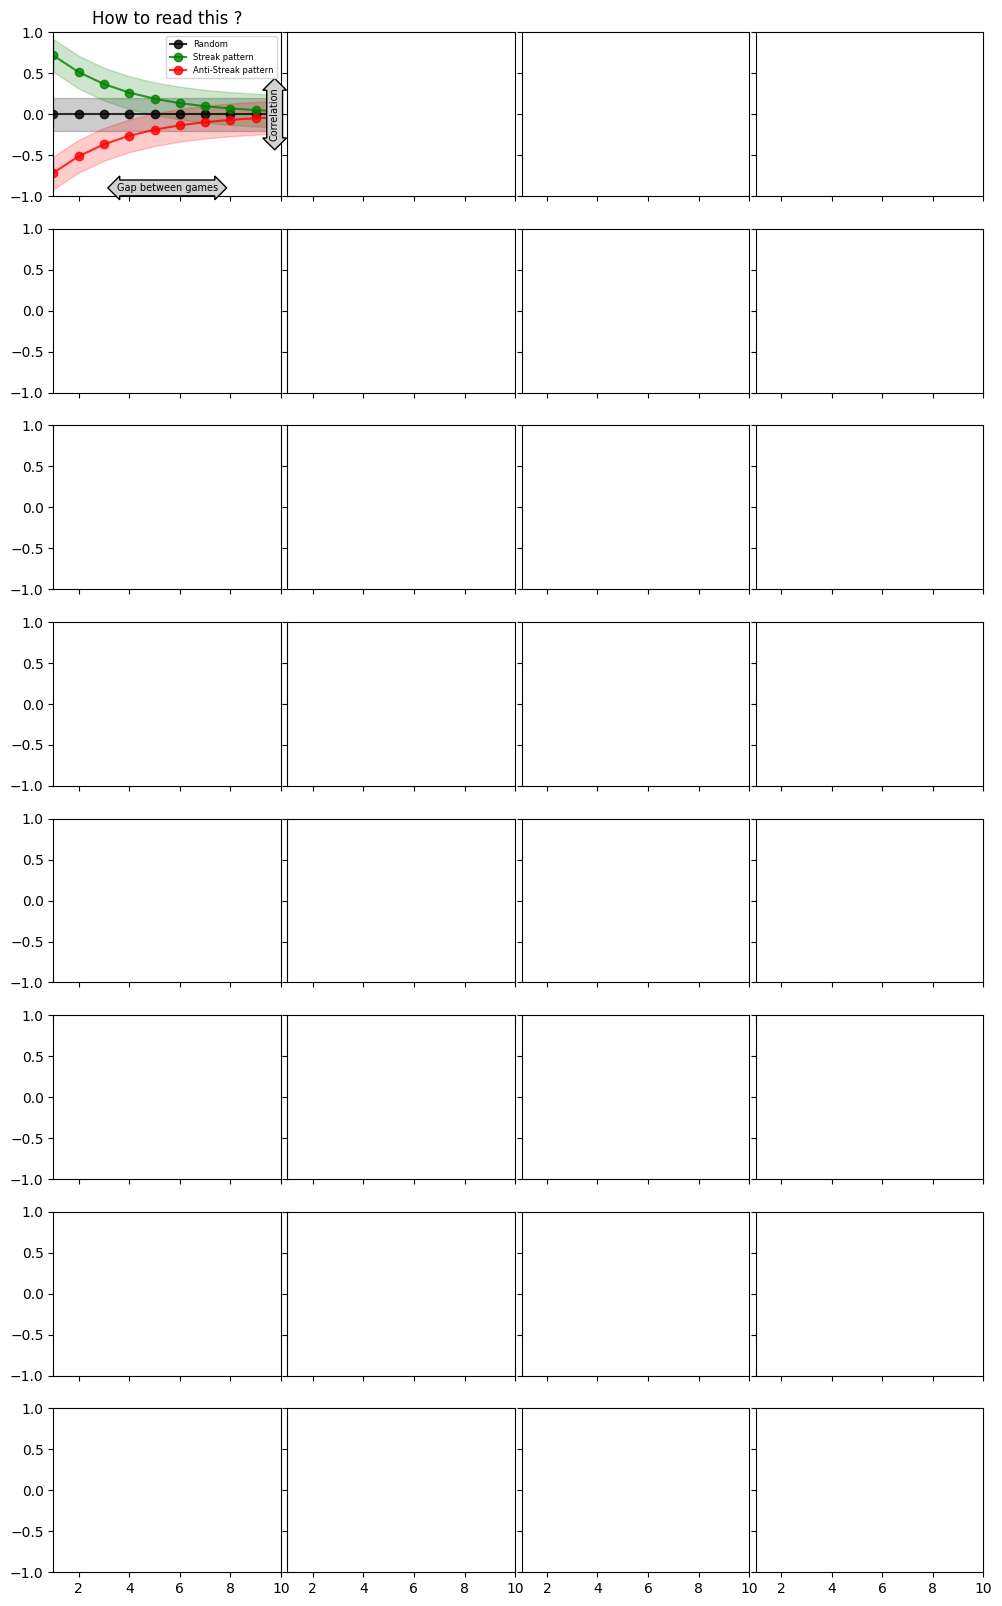

In [12]:
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.ticker import MultipleLocator

mosaic = [
    ['Demo']*6+ ['CHALLENGER']*6 + ['GRANDMASTER']*6 + ['MASTER']*6,
    ['DIAMOND I']*6 + ['DIAMOND II']*6 + ['DIAMOND III']*6 + ['DIAMOND IV']*6,
    ['EMERALD I']*6 + ['EMERALD II']*6 + ['EMERALD III']*6 + ['EMERALD IV']*6,
    ['PLATINUM I']*6 + ['PLATINUM II']*6 + ['PLATINUM III']*6 + ['PLATINUM IV']*6,
    ['GOLD I']*6 + ['GOLD II']*6 + ['GOLD III']*6 + ['GOLD IV']*6,
    ['SILVER I']*6 + ['SILVER II']*6 + ['SILVER III']*6 + ['SILVER IV']*6,
    ['BRONZE I']*6 + ['BRONZE II']*6 + ['BRONZE III']*6 + ['BRONZE IV']*6,
    ['IRON I']*6 + ['IRON II']*6 + ['IRON III']*6 + ['IRON IV']*6,
]

lags = np.arange(1, 11)

fig, axs = plt.subplot_mosaic(mosaic, sharex=True, sharey=True, figsize=(12,20))
axs['Demo'].set_xlim(1, 10)
axs['Demo'].set_ylim(-1, 1)
axs['Demo'].set_title('How to read this ?')

axs['Demo'].text(5.5, -0.9, "Gap between games", ha="center", va="center", rotation=0, size=7,
            bbox=dict(boxstyle="darrow,pad=0.3",
                      fc="lightgray", ec="black"))

axs['Demo'].text(9.75, 0, "Correlation", ha="center", va="center", rotation=90, size=7,
            bbox=dict(boxstyle="darrow,pad=0.3",
                      fc="lightgray", ec="black"))

axs['Demo'].plot(lags, np.zeros_like(lags), marker = 'o', color='black', label='Random', alpha=0.8)
axs['Demo'].fill_between(lags, -0.2*np.ones_like(lags), +0.2*np.ones_like(lags), alpha=0.2, color='black')

axs['Demo'].plot(lags, np.exp(-lags/3), marker = 'o', color='green', label='Streak pattern', alpha=0.8)
axs['Demo'].fill_between(lags, np.exp(-lags/3)-0.2, np.exp(-lags/3)+0.2, alpha=0.2, color='green')

axs['Demo'].plot(lags, -np.exp(-lags/3), marker = 'o', color='red', label='Anti-Streak pattern', alpha=0.8)
axs['Demo'].fill_between(lags, -np.exp(-lags/3)-0.2, -np.exp(-lags/3)+0.2, alpha=0.2, color='red')

axs['Demo'].legend(prop={'size': 6})

for i, (tier, color) in enumerate(zip(tier_list, colors)):


    auto_corr_tier = np.vstack(list(autocorrelation[tier].values()))
    name = tier.replace('_', ' ')
    axs[name].plot(
        lags, 
        np.median(auto_corr_tier, axis=0), 
        marker = 'o', label='Median', color=color
    )
    axs[name].fill_between(lags, *np.percentile(auto_corr_tier, [5, 95], axis=0), alpha=0.4, label='(5-95)%', color=color)
    axs[name].plot(lags, auto_corr_tier.T, color='grey', alpha=0.07, linestyle='dashdot')
    axs[name].grid(which='both')
    
    axs[name].xaxis.set_minor_locator(MultipleLocator(1))
    axs[name].yaxis.set_minor_locator(MultipleLocator(0.25))
    axs[name].set_title(name)
    axs[name].legend()

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Lag between games")
plt.ylabel("Correlation")
plt.savefig('autocorrelation.pdf', dpi=300, bbox_inches='tight')

In [13]:
import numpy as np 

simulation_size = 99
p = 1/2
p_streak = 0.8

history_random_list = []
history_correlated_list = []
history_anticorrelated_list = []

for i in range(1000):

    history_random = [0]
    history_correlated = [0]
    history_anticorrelated = [0]

    for _ in range(simulation_size):
        
        #previous = history_streak[-1]
        history_random.append(np.random.binomial(1, p))
        history_correlated.append(np.random.binomial(1, p_streak if history_correlated[-1] else 1 - p_streak))
        history_anticorrelated.append(np.random.binomial(1, p_streak if not history_anticorrelated[-1] else 1 - p_streak))

    history_random_list.append(history_random)
    history_correlated_list.append(history_correlated)
    history_anticorrelated_list.append(history_anticorrelated)

history_random = np.apply_along_axis(acf, 1, np.asarray(history_random_list), nlags = 10)[..., 1:]
history_correlated = np.apply_along_axis(acf, 1, np.asarray(history_correlated_list), nlags = 10)[..., 1:]
history_anticorrelated = np.apply_along_axis(acf, 1, np.asarray(history_anticorrelated_list), nlags = 10)[..., 1:]

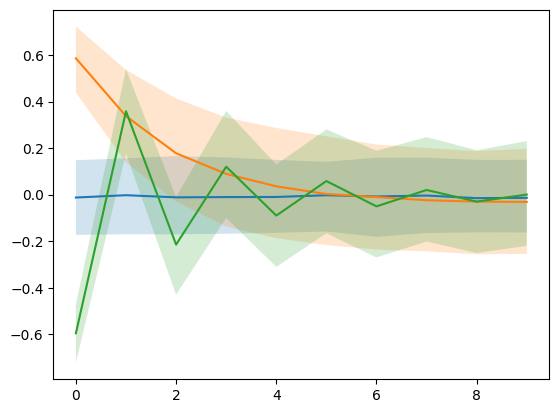

In [14]:
plt.plot(np.arange(10), np.median(history_random, axis=0))
plt.fill_between(np.arange(10), *np.percentile(history_random, [5, 95], axis=0), alpha=0.2)
plt.plot(np.arange(10), np.median(history_correlated, axis=0))
plt.fill_between(np.arange(10), *np.percentile(history_correlated, [5, 95], axis=0), alpha=0.2)
plt.plot(np.arange(10), np.median(history_anticorrelated, axis=0))
plt.fill_between(np.arange(10), *np.percentile(history_anticorrelated, [5, 95], axis=0), alpha=0.2)

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Assume the data setup as previously mentioned
# Separate matrices
random_matrix = np.asarray(history_random_list)[0:10, 1:60]
correlated_matrix = np.asarray(history_correlated_list)[0:10, 1:60]
anticorrelated_matrix = np.asarray(history_anticorrelated_list)[0:10, 1:60]

# Define colors for each series for consistency
color_random = 'rgba(0,100,80,0.5)'
color_correlated = 'rgba(0,176,246,0.5)'
color_anticorrelated = 'rgba(231,107,243,0.5)'

x_values = np.arange(10) + 1

# Adjusted plot code with shared color and linked visibility
# Create traces for the medians with legendgroup
trace_random = go.Scatter(
    x=x_values,
    y=np.median(history_random, axis=0),
    mode='lines',
    name='Random',
    line=dict(color=color_random),
    legendgroup='random'
)

trace_correlated = go.Scatter(
    x=x_values,
    y=np.median(history_correlated, axis=0),
    mode='lines',
    name='Correlated',
    line=dict(color=color_correlated),
    legendgroup='correlated'
)

trace_anticorrelated = go.Scatter(
    x=x_values,
    y=np.median(history_anticorrelated, axis=0),
    mode='lines',
    name='Anti-correlated',
    line=dict(color=color_anticorrelated),
    legendgroup='anticorrelated'
)

# Create traces for the percentiles fill with the same legendgroup and matching color
fill_random = go.Scatter(
    x=np.concatenate((x_values, x_values[::-1])),
    y=np.concatenate((
        np.percentile(history_random, 5, axis=0), 
        np.percentile(history_random, 95, axis=0)[::-1]
    )),
    fill='toself',
    fillcolor=color_random,
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Fill',
    showlegend=False,
    legendgroup='random'
)

fill_correlated = go.Scatter(
    x=np.concatenate((x_values, x_values[::-1])),
    y=np.concatenate((
        np.percentile(history_correlated, 5, axis=0),
        np.percentile(history_correlated, 95, axis=0)[::-1]
    )),
    fill='toself',
    fillcolor=color_correlated,
    line=dict(color='rgba(255,255,255,0)'),
    name='Correlated Fill',
    showlegend=False,
    legendgroup='correlated'
)

fill_anticorrelated = go.Scatter(
    x=np.concatenate((x_values, x_values[::-1])),
    y=np.concatenate((
        np.percentile(history_anticorrelated, 5, axis=0),
        np.percentile(history_anticorrelated, 95, axis=0)[::-1]
    )),
    fill='toself',
    fillcolor=color_anticorrelated,
    line=dict(color='rgba(255,255,255,0)'),
    name='Anti-correlated Fill',
    showlegend=False,
    legendgroup='anticorrelated'
)

# Create subplots with 3 rows for matrices and 1 big column for correlation plots
fig = make_subplots(
    rows=3, cols=2,
    column_widths=[0.65, 0.35],
    specs=[[{"type": "scatter", "rowspan":3}, {"type": "heatmap", "colspan": 1}],
           [None, {"type": "heatmap", "colspan": 1}],
           [None, {"type": "heatmap", "colspan": 1}]],
    subplot_titles=("", "Random", "Correlated", "Anti-correlated")
)

# Add heatmaps to the first column
fig.add_trace(
    go.Heatmap(
        z=random_matrix,
        colorscale=[[0, 'mediumvioletred'], [1, 'mediumseagreen']],
        showscale=False
    ),
    row=1, col=2
)

fig.add_trace(
    go.Heatmap(
        z=correlated_matrix,
        colorscale=[[0, 'mediumvioletred'], [1, 'mediumseagreen']],
        showscale=False
    ),
    row=2, col=2
)

fig.add_trace(
    go.Heatmap(
        z=anticorrelated_matrix,
        colorscale=[[0, 'mediumvioletred'], [1, 'mediumseagreen']],
        showscale=False
    ),
    row=3, col=2
)

# Add correlation plots to the second column spanning all three rows
# Add the fill traces first so they're behind the median traces to the second column
fig.add_trace(fill_random, row=1, col=1)
fig.add_trace(fill_correlated, row=1, col=1)
fig.add_trace(fill_anticorrelated, row=1, col=1)

# Add the median traces to the second column
fig.add_trace(trace_random, row=1, col=1)
fig.add_trace(trace_correlated, row=1, col=1)
fig.add_trace(trace_anticorrelated, row=1, col=1)
# Update layout for a cleaner look
fig.update_layout(
    #title_text="Vertical Matrix with Right-Side Correlation Traces",
    showlegend=True
)

# Hide tick labels on heatmaps
fig.update_xaxes(showticklabels=False, row=1, col=2)
fig.update_xaxes(showticklabels=False, row=2, col=2)
fig.update_xaxes(showticklabels=False, row=3, col=2)
fig.update_yaxes(showticklabels=False, row=1, col=2)
fig.update_yaxes(showticklabels=False, row=2, col=2)
fig.update_yaxes(showticklabels=False, row=3, col=2)
fig.update_yaxes(range=(-1, 1), row=1, col=1)
fig.update_xaxes(range=(1, 8), row=1, col=1)

fig['layout']['xaxis1']['title']="Lag between games"
fig['layout']['yaxis1']['title']="Correlation coefficient"

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    width=700, height=800/3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=0.6
    )
)

fig.update_xaxes(showgrid=True, minor=dict(showgrid=True), row=1, col=1)
fig.update_yaxes(showgrid=True, minor=dict(showgrid=True), row=1, col=1, title_standoff = 0)

# Show the plot
fig.show()

with open("docs/loserQ/assets/simulated_correlation.json", "w") as f:
    f.write(fig.to_json())